# Projet 7

## Modelisation

## 1. Chargement des donnees

### 1.1 Import libraries

In [61]:
# Librairies standard
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randrange
import pickle


# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Embedding
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Modélisation
import torch
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense,  Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# embeddings
from gensim.models import Word2Vec
import gensim.downloader as api

# mlflow
import mlflow
import mlflow.sklearn
import mlflow.keras

### 1.2 Fonctions

In [63]:
# Initialiser une liste vide pour stocker tous les scores
all_scores = []


def evaluate_model_and_plot(name, X_train_vectorized, X_test_vectorized, y_train, y_test, model_type='Logistic Regression'):
    """
    Évalue un modèle de classification et trace la courbe ROC et la matrice de confusion.

    Paramètres:
    name (str): Le nom du modèle.
    X_train_vectorized (array): Les caractéristiques d'entraînement vectorisées.
    X_test_vectorized (array): Les caractéristiques de test vectorisées.
    y_train (array): Les étiquettes d'entraînement.
    y_test (array): Les étiquettes de test.
    model_type (str, optionnel): Le type de modèle à utiliser. Par défaut, c'est 'Logistic Regression'.

    Retourne:
    None
    """
        
    # Démarrer une nouvelle exécution avec MLflow
    with mlflow.start_run(run_name=name):
        # Log the model type
        mlflow.log_param("model_type", model_type)

        # Sélectionner le modèle en fonction du type spécifié
        if model_type == 'Logistic Regression':
            model = LogisticRegression()
        elif model_type == 'MultinomialNB':
            model = MultinomialNB()
        elif model_type == 'XGBoost':
            model = xgb.XGBClassifier()

        # Entraîner le modèle
        model.fit(X_train_vectorized, y_train)

        # Faire des prédictions sur l'ensemble de test
        y_pred = model.predict(X_test_vectorized)

        # Calculer la matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        # Normaliser la matrice de confusion
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Calculer les scores du modèle
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        # Stocker tous les scores dans un dictionnaire
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        # Store all scores in a dictionary
        model_scores = {
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'ROC AUC': roc_auc
        }

        # Ajouter les scores du modèle à la liste
        all_scores.append(model_scores)

        # Enregistrer le modèle avec MLflow
        mlflow.sklearn.log_model(model, "model")

        # Tracer la courbe ROC et la matrice de confusion côte à côte
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, color='darkorange',
                     lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('Receiver Operating Characteristic (ROC)')
        axes[0].legend(loc="lower right")

        # Matrice de oconfusion
        cm_display = ConfusionMatrixDisplay(cm_normalized).plot(cmap='Blues', ax=axes[1], xticks_rotation='vertical')
        axes[1].set_title('Confusion Matrix')

        plt.suptitle(f'Model Results: {name}')
        plt.show()
        
    mlflow.end_run()

In [65]:
evaluationScore = []
def simpleLSTM(embedded_layer, Name):
    """
    Construit, entraîne et évalue un modèle LSTM simple.

    Paramètres:
    embedded_layer (Layer): La couche d'embedding à utiliser.
    Name (str): Le nom du modèle.

    Retourne:
    Tuple[Model, History]: Le modèle entraîné et l'historique de l'entraînement.
    """
    # Démarrer une nouvelle exécution avec MLflow
    with mlflow.start_run(run_name=Name):
        # Enregistrer le nom du modèle avec MLflow
        mlflow.log_param("model_name", Name)

        # Construire le modèle
        lstm_model = Sequential()
        lstm_model.add(embedded_layer)
        lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))),
        lstm_model.add(Dense(units=64, activation='relu'))
        lstm_model.add(Dropout(0.5))
        lstm_model.add(Dense(units=1, activation='sigmoid'))

        # Afficher le résumé du modèle
        print(lstm_model.summary())

        # Compiler le modèle
        lstm_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

        # Entraîner le modèle
        history = lstm_model.fit(x_train, y_train,
                                 batch_size=512,
                                 epochs=10,
                                 verbose=1,
                                 validation_split=0.1,
                                 callbacks=callbacks)

        # Évaluer le modèle
        score = lstm_model.evaluate(x_test, y_test, verbose=0)
        print(f"{Name} model Score--->", score)
        evaluationScore.append((Name,score[0],score[1]))

        # Enregistrer les métriques avec MLflow
        mlflow.log_metric("loss", score[0])
        mlflow.log_metric("accuracy", score[1])

        # Enregistrer le modèle avec MLflow
        mlflow.keras.log_model(lstm_model, f'{Name}_model')

        # Sauvegarder le modèle
        lstm_model.save(f'{save_path}/{Name}_model.h5')
    # Terminer l'exécution avec MLflow
    mlflow.end_run()
    
    return (lstm_model, history)

In [66]:
def lossAndAccuracy(hist, title):
    """
    Affiche les courbes de perte et de précision d'un modèle en fonction des epochs.

    Args:
        hist: L'historique de l'entraînement du modèle.
        title (str): Le titre à afficher au-dessus des graphiques.

    """
    acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']
    loss, val_loss = hist.history['loss'], hist.history['val_loss']
    epochs = range(len(acc))


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Précision d\'entraînement et de validation')
    plt.ylabel('Précision')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Perte d\'entraînement et de validation')
    plt.ylabel('Perte')
    plt.xlabel('Epoch')
    plt.legend()
    plt.suptitle(f'model : {title}')
    plt.show()

In [67]:
def createEmbeddingMatrix(model, modelName):
    """
    Crée une matrice d'incorporation à partir d'un modèle pré-entraîné.

    Args:
        model: Le modèle pré-entraîné à partir duquel extraire les embeddings.
        modelName (str): Le nom du modèle ('Glove' ou autre) pour sélectionner la méthode appropriée.

    Returns:
        numpy.array: La matrice d'incorporation.

    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimensions))
    for word, i in tokenizer.word_index.items():
        if modelName == 'Glove':
            embedding_value = embedding_vector.get(word)
            if embedding_value is not None:
                embedding_matrix[i] = embedding_value
        else:
            if word in model.wv:
                embedding_matrix[i] = model.wv[word]
    print("Embedded matrix shape for ", modelName, ":", embedding_matrix.shape)
    return embedding_matrix


In [68]:
def preprocess_data(data, target_col, text_col, embedding_dimensions=300, input_length=100):
    """
    Prétraite les données pour l'entraînement du modèle.

    Paramètres:
    data (DataFrame): Le jeu de données à prétraiter.
    target_col (str): Le nom de la colonne cible.
    text_col (str): Le nom de la colonne contenant le texte.
    embedding_dimensions (int, optionnel): La dimension des embeddings de mots. Par défaut, c'est 300.
    input_length (int, optionnel): La longueur d'entrée pour le modèle. Par défaut, c'est 100.

    Retourne:
    Tuple: Les ensembles d'entraînement et de test, la taille du vocabulaire, la dimension des embeddings, la longueur d'entrée, le modèle Word2Vec et le tokenizer.
    """
    # Division du jeu de données en ensembles d'entraînement, de test et de validation
    df_train, df_test_val, y_train, y_test_val = train_test_split(
        data[text_col],
        data[target_col],
        test_size=0.3,
        random_state=0
    )

    # Division de l'ensemble de test et de validation en ensembles distincts
    df_test, df_val, y_test, y_val = train_test_split(
        df_test_val,
        y_test_val,
        test_size=0.5,
        random_state=0
    )

    # Tokenisation des tweets traités
    textToken = [_text.split() for _text in data[text_col]]

    # Définition du modèle Word2Vec
    w2v_model = Word2Vec(vector_size=embedding_dimensions,  # Dimension des embeddings de mots
                         window=6,                          # Fenêtre contextuelle pour les mots lors de l'entraînement
                         min_count=3,                       # Seuil minimum de fréquence des mots
                         workers=8,                         # Nombre de travailleurs
                         epochs=20)                         # Nombre d'époques d'entraînement sur le corpus

    # Construction du vocabulaire pour le modèle Word2Vec
    gen_vocab_w2v = w2v_model.build_vocab(textToken)

    # Tokenisation des données
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data[text_col])

    # Création du vocabulaire
    vocab_size = len(tokenizer.word_index) + 1

    # Tokenisation et padding des ensembles d'entraînement et de test
    x_train = pad_sequences(tokenizer.texts_to_sequences(df_train), maxlen=input_length)
    x_test = pad_sequences(tokenizer.texts_to_sequences(df_test), maxlen=input_length)

    return x_train, x_test, y_train, y_test, vocab_size, embedding_dimensions, input_length, w2v_model, tokenizer



def create_embedding_layer(embedding_matrix, vocab_size, embedding_dimensions, input_length, trainable=False):
    """
    Crée une couche d'embedding pour le modèle.

    Paramètres:
    embedding_matrix (array): La matrice d'embedding précalculée.
    vocab_size (int): La taille du vocabulaire.
    embedding_dimensions (int): La dimension des embeddings.
    input_length (int): La longueur d'entrée pour le modèle.
    trainable (bool, optionnel): Indique si les poids de la couche sont entraînables. Par défaut, c'est False.

    Retourne:
    Layer: La couche d'embedding.
    """
    return Embedding(vocab_size,                # Taille du vocabulaire
                     embedding_dimensions,      # Dimension des embeddings
                     weights=[embedding_matrix], # Matrice d'embedding précalculée
                     input_length=input_length, # Longueur d'entrée
                     trainable=trainable)           # Indique si les poids de la couche sont entraînables

### 1.3 Import fichier

In [69]:
# creation variable data
save_path = '../model/'
path = '../data/processed/'

In [70]:
# import des fichiers
data = pd.read_csv(path + 'data.csv')

In [71]:
# affichage df
display(data.head(2))

,target,id,date,flag,user,text,lemm_tweet,stemm_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda got david carr ...,switchfoot awww bummer shoulda got david carr ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,upset updat facebook text might cri result sch...


In [72]:
data.dropna(inplace=True)

### 2. Preparation modelisation

### 2.1 Defintion variables

In [73]:
# Separation des features (X) and target variable (y)
X_stem = data['stemm_tweet']  # Features
X_lemm = data['lemm_tweet']
y = data['target'] # Target variable

2.2 split donnees

In [74]:
# Split du dataset en training et testing sets
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y, test_size=0.2, random_state=42)

In [75]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lemm, y, test_size=0.2, random_state=42)

### 2.3 vectorization donnees

In [76]:
# Preprocess text data using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)  # Limit à 1000 features pour simplicité
X_train_vectorized_stem = vectorizer.fit_transform(X_train_stem)
X_test_vectorized_stem = vectorizer.transform(X_test_stem)
X_train_vectorized_lem = vectorizer.fit_transform(X_train_lem)
X_test_vectorized_lem = vectorizer.transform(X_test_lem)

### 2.4 Modelisation

#### 2.4.1 Modele Naive

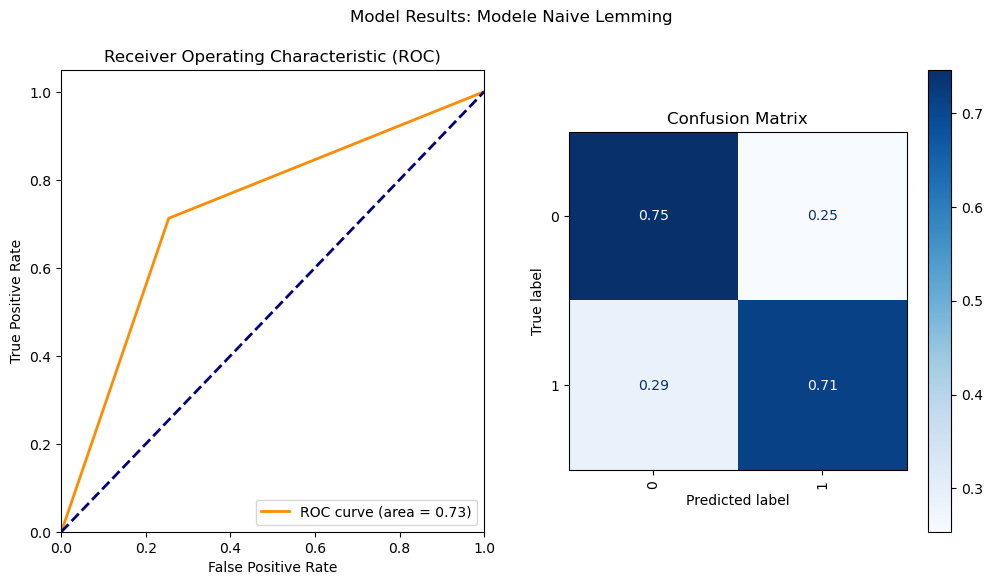

In [77]:
evaluate_model_and_plot('Modele Naive Lemming',X_train_vectorized_lem, X_test_vectorized_lem, y_train_lem, y_test_lem, model_type='MultinomialNB')

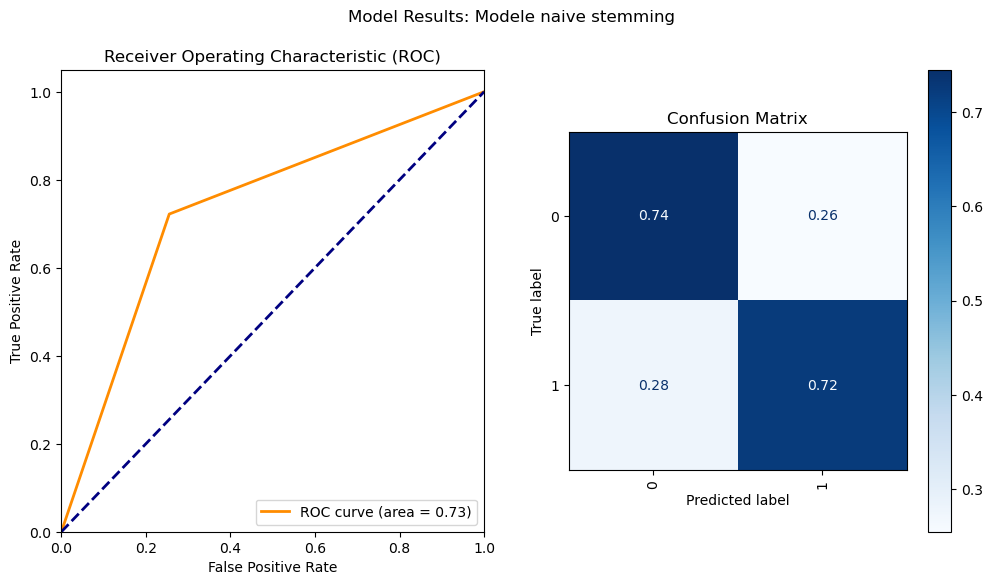

In [78]:
evaluate_model_and_plot('Modele naive stemming', X_train_vectorized_stem, X_test_vectorized_stem, y_train_stem, y_test_stem, model_type='MultinomialNB')

#### 2.4.2 Regression logistique

c:\Users\Zacca\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


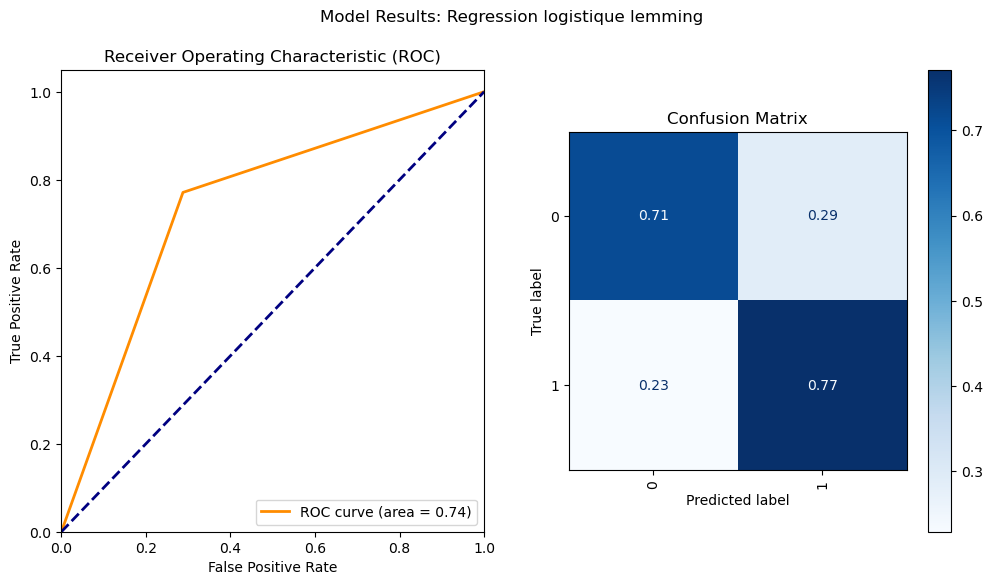

In [79]:
# Call the function for lemmatized data
evaluate_model_and_plot('Regression logistique lemming', X_train_vectorized_lem, X_test_vectorized_lem, y_train_lem, y_test_lem, model_type='Logistic Regression')

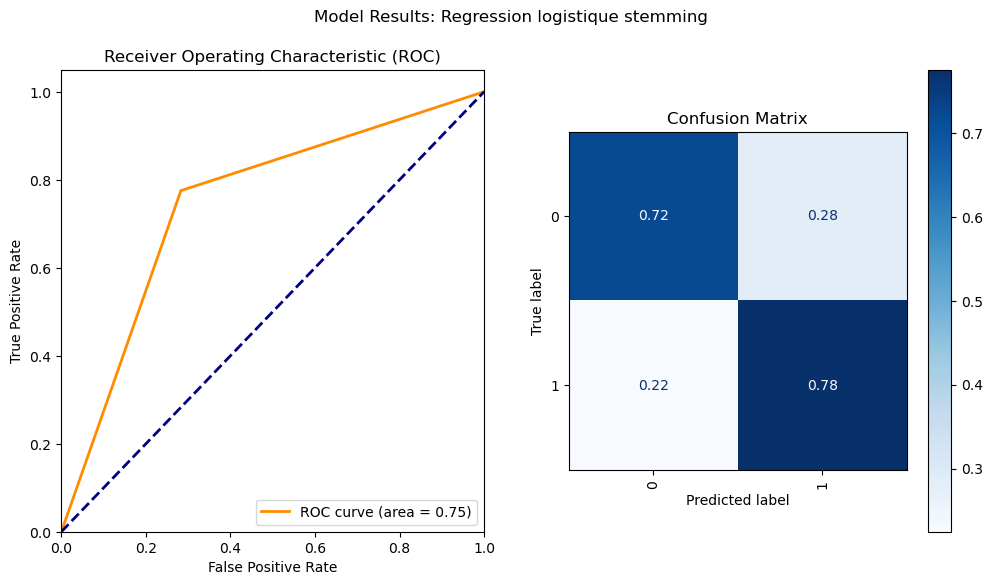

In [80]:
evaluate_model_and_plot('Regression logistique stemming', X_train_vectorized_stem, X_test_vectorized_stem, y_train_stem, y_test_stem, model_type='Logistic Regression')

#### 2.4.3 Xgboost

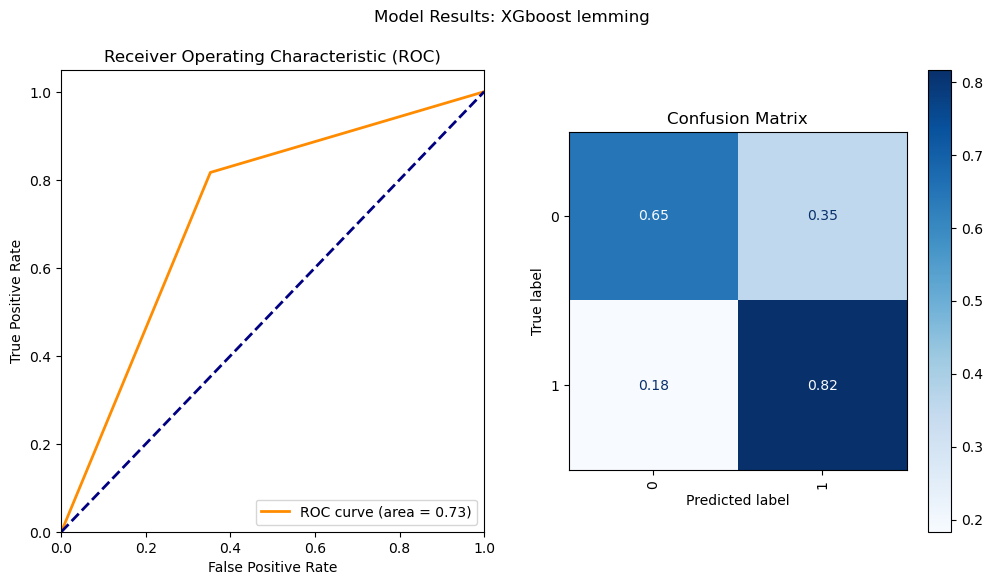

In [81]:
evaluate_model_and_plot('XGboost lemming', X_train_vectorized_lem, X_test_vectorized_lem, y_train_lem, y_test_lem, model_type='XGBoost')

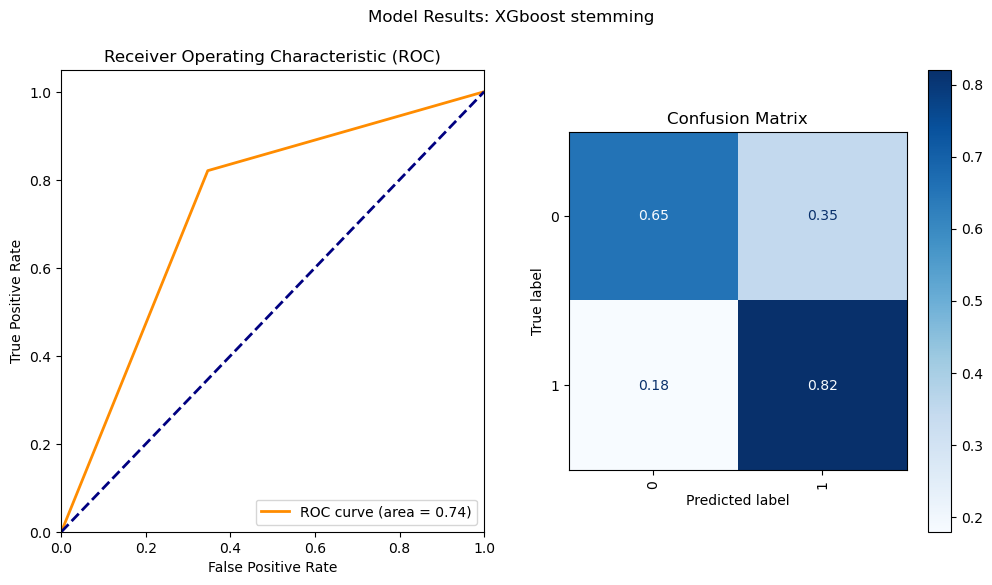

In [82]:
evaluate_model_and_plot('XGboost stemming',X_train_vectorized_stem, X_test_vectorized_stem, y_train_stem, y_test_stem, model_type='XGBoost')

#### 2.4.4 Evaluation modeles

In [83]:
scores_df = pd.DataFrame(all_scores)
scores_df = scores_df.sort_values(by='Accuracy', ascending=False)
scores_df

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
3,Regression logistique stemming,0.746332,0.733793,0.775192,0.753925,0.746258
2,Regression logistique lemming,0.741868,0.729405,0.771139,0.749692,0.741793
5,XGboost stemming,0.737386,0.704326,0.820609,0.758034,0.737171
1,Modele naive stemming,0.733375,0.739869,0.721949,0.730799,0.733404
4,XGboost lemming,0.732272,0.699595,0.816537,0.753556,0.732054
0,Modele Naive Lemming,0.729189,0.738232,0.712364,0.725067,0.729233


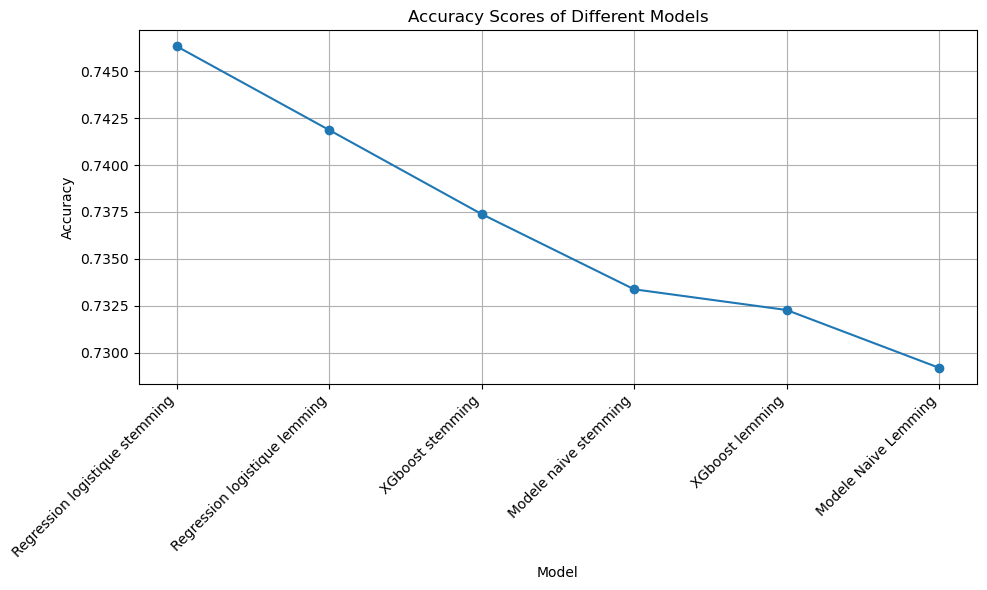

In [84]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scores_df['Model'], scores_df['Accuracy'], marker='o', linestyle='-')

# Adding labels
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores of Different Models')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.grid(True)  # Add gridlines for better visualization

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## 3. LSTM

### 3.1 Preparation donnees

In [92]:
# Tweets d'échantillon
sample_data = data.sample(n=30000, random_state=42)

In [86]:
# Initialisation d'un dictionnaire pour stocker les vecteurs d'embedding
embedding_vector = {}

# Chargement du fichier GloVe contenant les vecteurs d'embedding
with open('../input/glove.6B.300d.txt', encoding='utf-8') as f:
    # Parcours de chaque ligne du fichier
    for line in f:
        # Séparation des valeurs de la ligne
        values = line.split()
        # Extraction du mot
        word = values[0]
        # Extraction des coefficients d'embedding
        coef = np.array(values[1:], dtype='float32')
        # Stockage du mot et de ses coefficients dans le dictionnaire
        embedding_vector[word] = coef

In [93]:
callbacks = [
    ReduceLROnPlateau(factor=0.1, min_lr=0.001, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3)
]

### 3.2 LSTM avec lemming

In [94]:
x_train, x_test, y_train, y_test, vocab_size, embedding_dimensions, input_length,w2v_model, tokenizer = preprocess_data(sample_data, 'target', 'lemm_tweet')
embedding_layer_word2vec = create_embedding_layer(createEmbeddingMatrix(w2v_model, "Word2vec"), vocab_size, embedding_dimensions, input_length)
simpleLSTMWord2vec = simpleLSTM(embedding_layer_word2vec,'Modèle LSTM avec embeddings Word2Vec et lemming')

Embedded matrix shape for  Word2vec : (36488, 300)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          10946400  
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 100, 64)           16448     
                                                                 
 dropout_3 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_7 (Dense)             (None, 100, 1)            65        
                                                                 
Total params: 11,402,209
Trainable params: 455,809
Non-trainable para

2024/04/15 11:11:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Modèle LSTM avec embeddings Word2Vec et lemming model Score---> [0.6930880546569824, 0.5064444541931152]


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp96h591rf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp96h591rf\model\data\model\assets


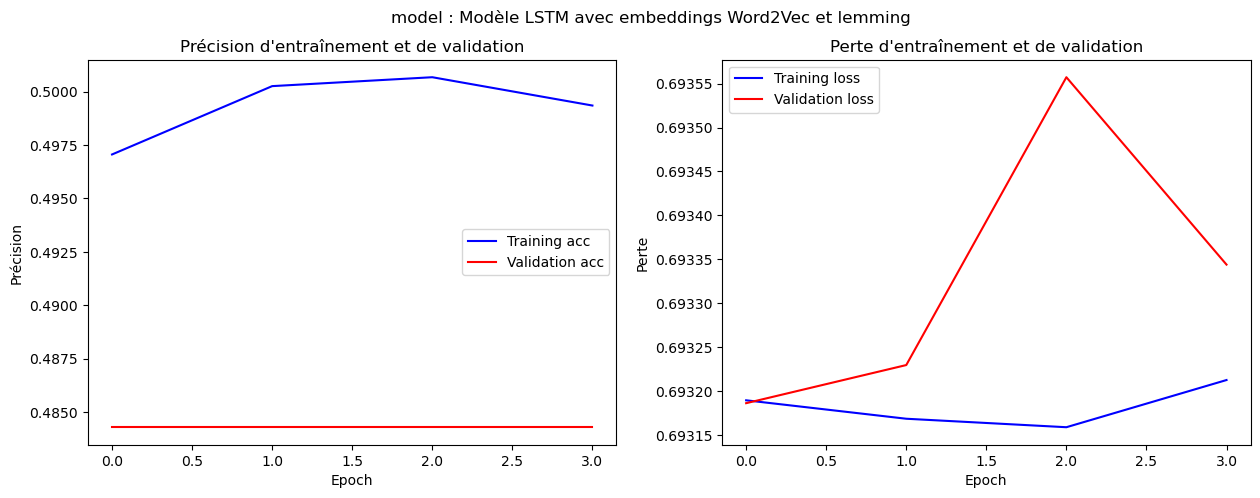

In [95]:
# Affichage des courbes de ploss et de précision pour le modèle LSTM avec des embeddings Word2Vec
lossAndAccuracy(simpleLSTMWord2vec[1], 'Modèle LSTM avec embeddings Word2Vec et lemming')

In [96]:
x_train, x_test, y_train, y_test, vocab_size, embedding_dimensions, input_length,w2v_model,tokenizer = preprocess_data(sample_data, 'target', 'lemm_tweet')

# Save the tokenizer
with open('../tokenizer/tokenizer_l_glo.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

embedding_layer_glove = create_embedding_layer(createEmbeddingMatrix(embedding_vector, 'Glove'), vocab_size, embedding_dimensions, input_length)
simpleLSTMWord2vec = simpleLSTM(embedding_layer_glove,'Modèle LSTM avec embeddings Glove et Lemming')

Embedded matrix shape for  Glove : (36488, 300)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          10946400  
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 100, 64)           16448     
                                                                 
 dropout_4 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_9 (Dense)             (None, 100, 1)            65        
                                                                 
Total params: 11,402,209
Trainable params: 455,809
Non-trainable params:

2024/04/15 11:49:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Modèle LSTM avec embeddings Glove et Lemming model Score---> [0.5451125502586365, 0.7310935854911804]


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpu6_g3ck4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpu6_g3ck4\model\data\model\assets


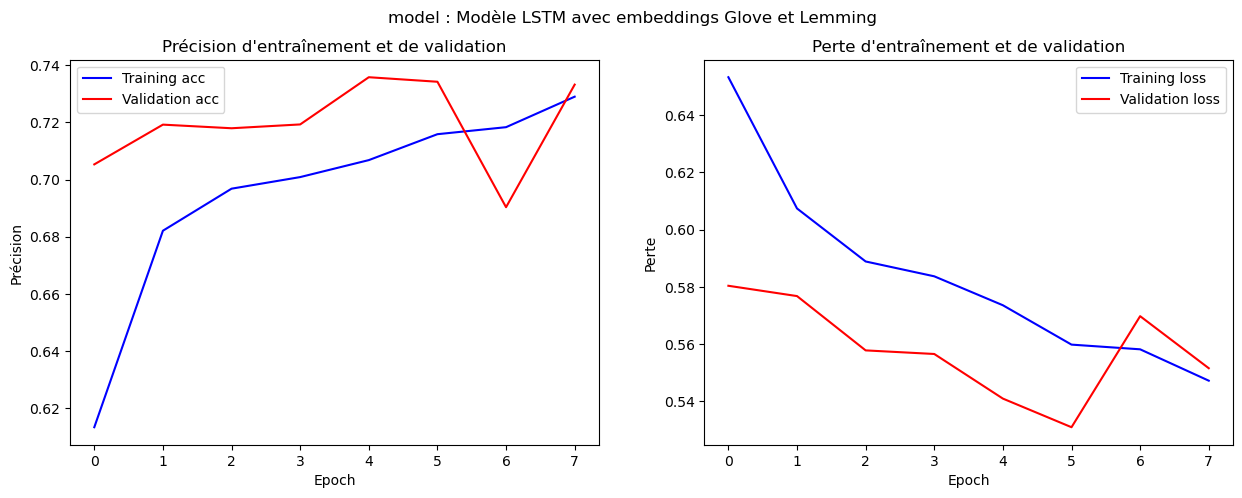

In [97]:
# Affichage des courbes de ploss et de précision pour le modèle LSTM avec des embeddings Word2Vec
lossAndAccuracy(simpleLSTMWord2vec[1], 'Modèle LSTM avec embeddings Glove et Lemming')

### 3.3 LSTM avec Stemming

In [98]:
x_train, x_test, y_train, y_test, vocab_size, embedding_dimensions, input_length,w2v_model,tokenizer = preprocess_data(sample_data, 'target', 'stemm_tweet')
embedding_layer_word2vec = create_embedding_layer(createEmbeddingMatrix(w2v_model, "Word2vec"), vocab_size, embedding_dimensions, input_length)
simpleLSTMWord2vec = simpleLSTM(embedding_layer_word2vec,'Modèle LSTM avec embeddings Word2Vec et stemming')

Embedded matrix shape for  Word2vec : (33246, 300)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          9973800   
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 100, 64)           16448     
                                                                 
 dropout_5 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_11 (Dense)            (None, 100, 1)            65        
                                                                 
Total params: 10,429,609
Trainable params: 455,809
Non-trainable para

2024/04/15 12:14:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Modèle LSTM avec embeddings Word2Vec et stemming model Score---> [0.6931307911872864, 0.5064444541931152]


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpg6jcrd4m\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpg6jcrd4m\model\data\model\assets


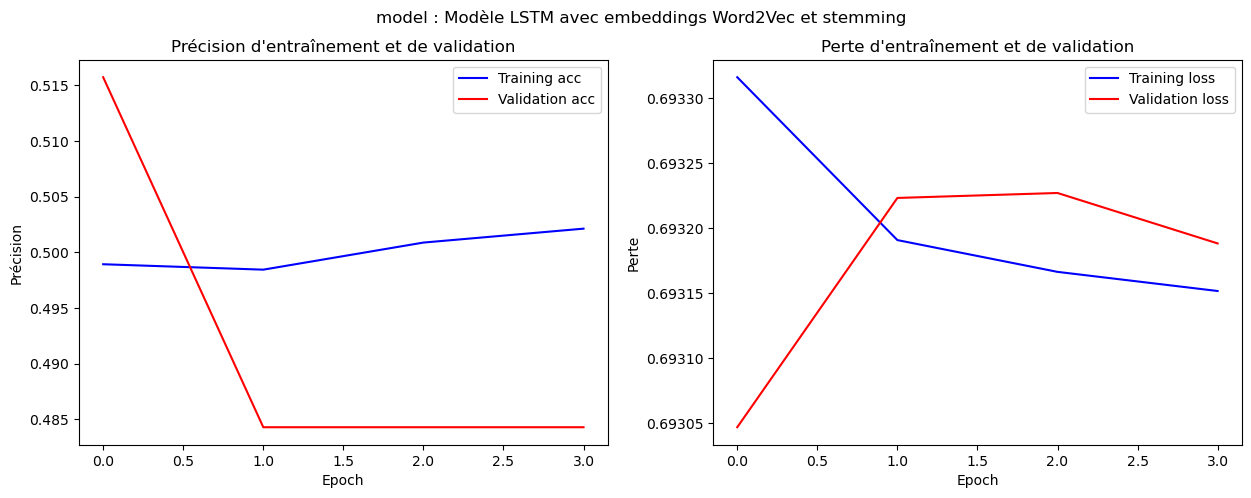

In [99]:
# Affichage des courbes de ploss et de précision pour le modèle LSTM avec des embeddings Word2Vec
lossAndAccuracy(simpleLSTMWord2vec[1], 'Modèle LSTM avec embeddings Word2Vec et stemming')

In [100]:
x_train, x_test, y_train, y_test, vocab_size, embedding_dimensions, input_length,w2v_model,tokenizer = preprocess_data(sample_data, 'target', 'stemm_tweet')
embedding_layer_glove = create_embedding_layer(createEmbeddingMatrix(embedding_vector, 'Glove'), vocab_size, embedding_dimensions, input_length)
simpleLSTMWord2vec = simpleLSTM(embedding_layer_glove,'Modèle LSTM avec embeddings Glove et stemming')

Embedded matrix shape for  Glove : (33246, 300)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          9973800   
                                                                 
 bidirectional_6 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 100, 64)           16448     
                                                                 
 dropout_6 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_13 (Dense)            (None, 100, 1)            65        
                                                                 
Total params: 10,429,609
Trainable params: 455,809
Non-trainable params:

2024/04/15 13:21:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Modèle LSTM avec embeddings Glove et stemming model Score---> [0.5447440147399902, 0.7197736501693726]


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpl1m6grek\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpl1m6grek\model\data\model\assets


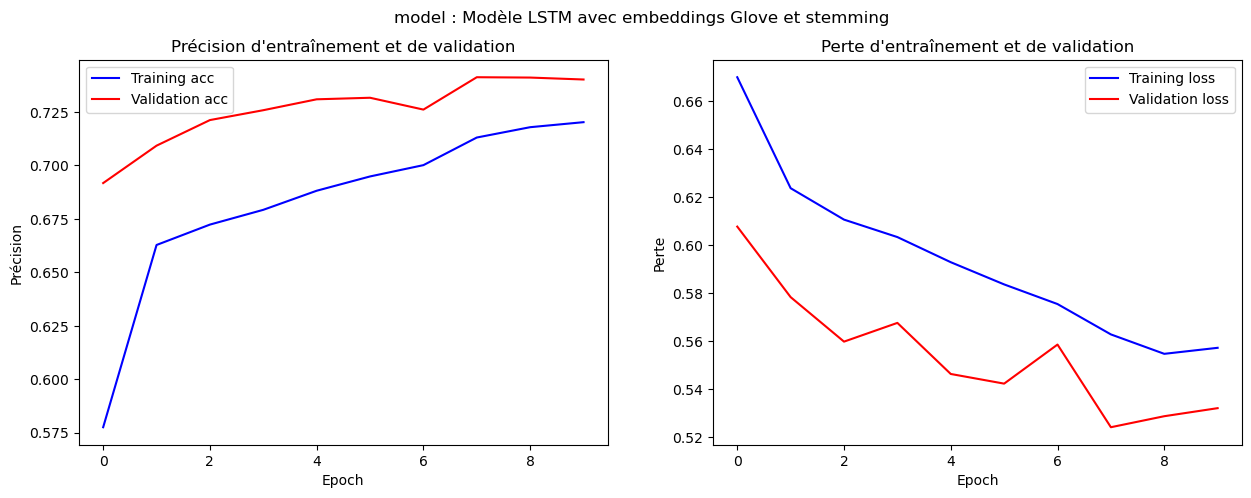

In [101]:
# Affichage des courbes de ploss et de précision pour le modèle LSTM avec des embeddings Word2Vec
lossAndAccuracy(simpleLSTMWord2vec[1], 'Modèle LSTM avec embeddings Glove et stemming')

### 3.4 Model comparaison

In [102]:
scores_lstm_df = pd.DataFrame(evaluationScore)

# Renommer les colonnes
scores_lstm_df.columns = ['Model','Loss','Accuracy']
# Trier par la colonne 'Précision'
scores_lstm_df_sorted = scores_lstm_df.sort_values(by='Accuracy', ascending=False)
# Afficher le DataFrame trié
scores_lstm_df_sorted

,Model,Loss,Accuracy
1,Modèle LSTM avec embeddings Glove et Lemming,0.545113,0.731094
3,Modèle LSTM avec embeddings Glove et stemming,0.544744,0.719774
0,Modèle LSTM avec embeddings Word2Vec et lemming,0.693088,0.506444
2,Modèle LSTM avec embeddings Word2Vec et stemming,0.693131,0.506444


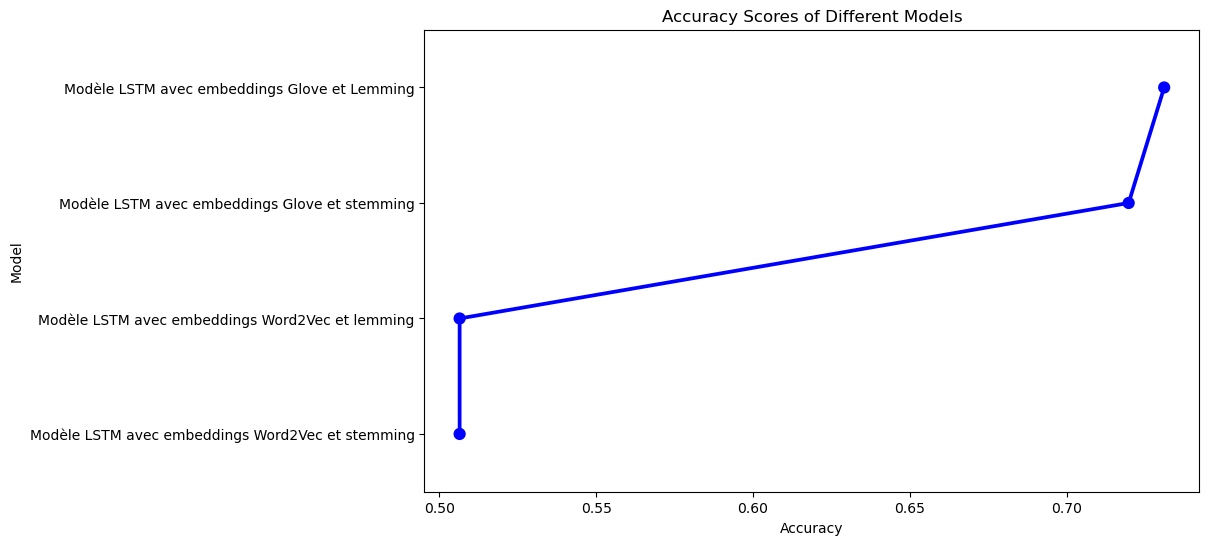

In [103]:
# Plotting
plt.figure(figsize=(10, 6))
sns.pointplot(data=scores_lstm_df_sorted, x='Accuracy', y='Model', color='blue')

# Adding labels
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy Scores of Different Models')

plt.show()